In [15]:
!git clone https://github.com/jgscott/STA380.git

fatal: destination path 'STA380' already exists and is not an empty directory.


**Importing Necessary Libraries**

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


**Defining device to run the CNN model**

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Loading and Preparing the dataset for model training and testing**

In [9]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = ImageFolder(root='STA380/data/EuroSAT_RGB', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

**Defining the Neural Network**

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 11)  # 11 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

**Training the Neural Network Model on 10 Epocs**

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):  # Number of epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

**Evaluating Model Accuracy**

In [12]:
correct_preds = 0
total_preds = 0
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted_labels == labels).sum().item()
        all_predictions.extend(predicted_labels.cpu())
        all_true_labels.extend(labels.cpu())

accuracy = correct_preds / total_preds
print(f'Overall Test Accuracy: {accuracy * 100:.2f}%')

Overall Test Accuracy: 82.54%


**Display Sample Images with Predictions**

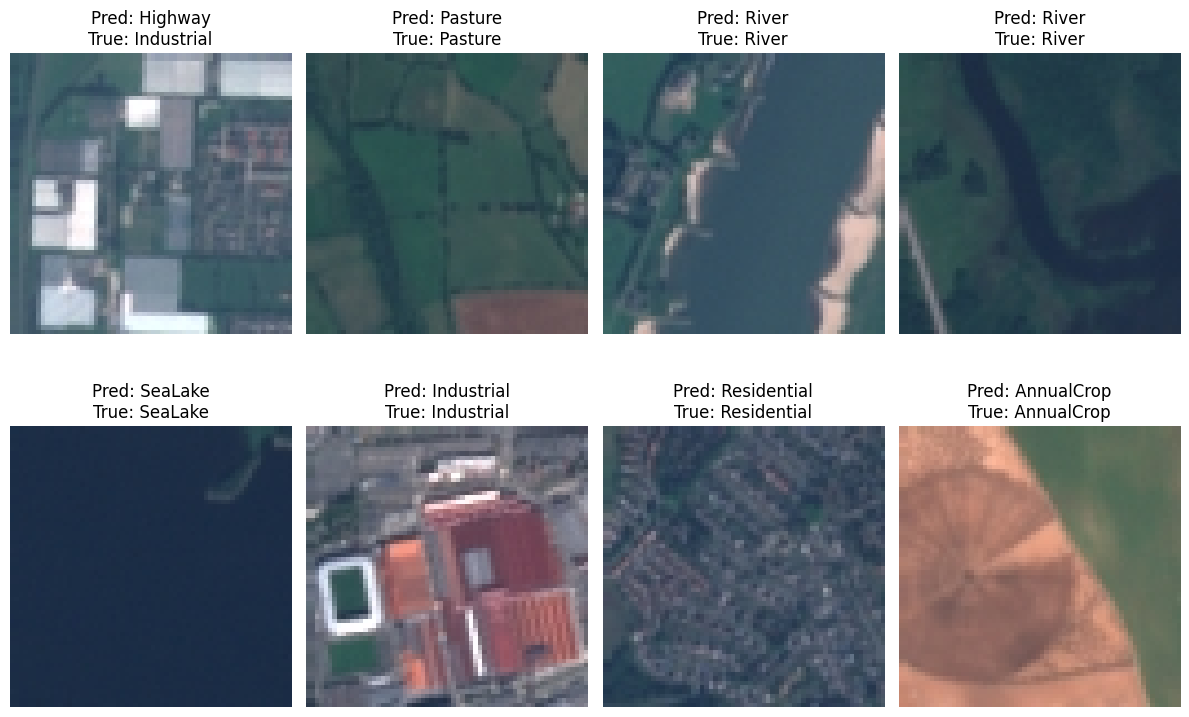

In [13]:
class_labels = dataset.classes  # Retrieve class names

# Get a batch of test images
test_iter = iter(test_loader)
sample_images, sample_labels = next(test_iter)

# Move images to the same device as the model
sample_images = sample_images.to(device)
sample_outputs = model(sample_images)
_, sample_predictions = torch.max(sample_outputs, 1)

# Plot the sample images with predictions
plt.figure(figsize=(12, 8))
for i in range(8):  # Display 8 images
    plt.subplot(2, 4, i+1)
    plt.imshow(sample_images[i].cpu().permute(1, 2, 0))  # Convert tensor to image format
    plt.title(f"Pred: {class_labels[sample_predictions[i].item()]}\nTrue: {class_labels[sample_labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**Confusion Matrix**

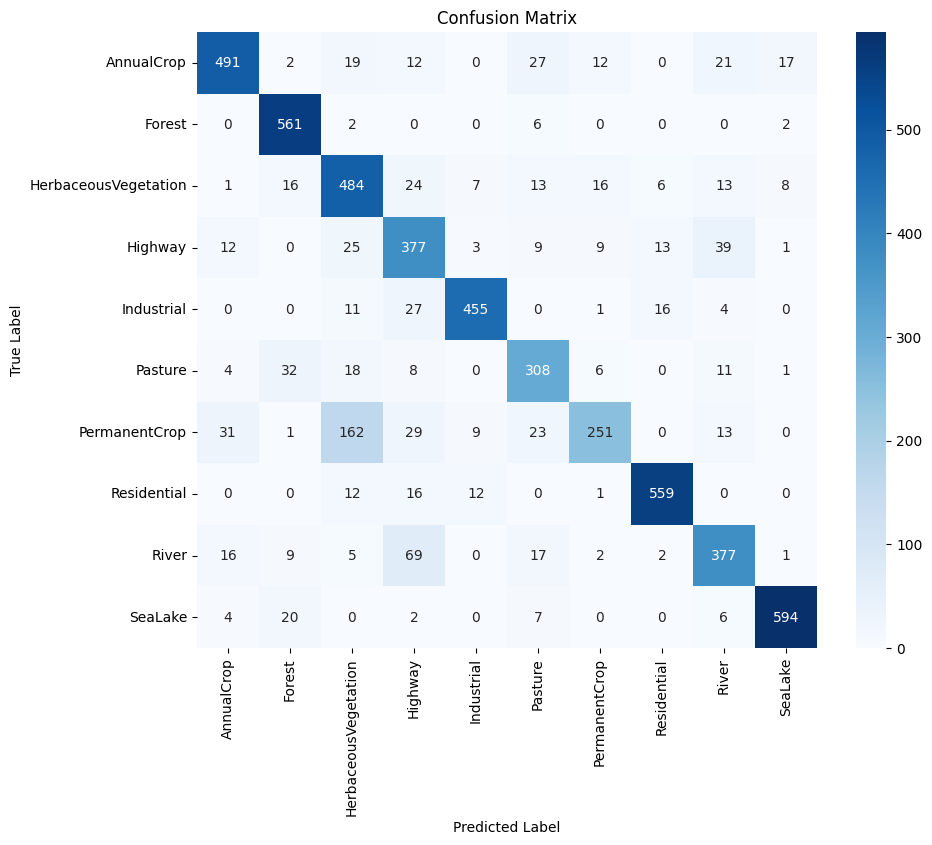

In [14]:
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Summary**


* The model is capable of correctly classifying many distinct classes, as observed in the correctly classified images, such as Pasture, River, SeaLake, Industrial, Residential, and AnnualCrop.
* However, the model faces challenges when differentiating between visually similar or overlapping patterns.

For example:
1. **Highway vs Industrial:** The model incorrectly classified an Industrial area as a Highway. This may be due to the presence of straight lines or structures resembling roads in industrial zones.
2. **AnnualCrop vs PermanentCrop:** The visual similarity of field patterns in agricultural regions, such as circular patterns of crop irrigation, leads to confusion between these two classes.
4. **River vs Highway:** Both classes exhibit linear or winding shapes that could appear similar in satellite imagery, causing misclassifications in some cases.


* In conclusion, while the model performs well with distinct classes, it struggles with those that share similar visual characteristics.
* Additional model complexity may help reduce these misclassifications, but a targeted approach to improve performance on visually similar categories, possibly through fine-tuning or additional feature extraction, could provide better results.
